In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"
!unzip -q dataset.zip

In [ ]:
!unzip -q dataset/dualclass.zip
!unzip -q dataset/test2classes.zip

In [ ]:
import torch
import torch.nn as nn




class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution 
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and 
        #we refer to our network with such a bottleneck layer, i.e., 
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` , 
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments 
        #consist of a batch normalization layer and an 1×1 
        #convolutional layer followed by a 2×2 average pooling 
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=2):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution 
        #with 16 (or twice the growth rate for DenseNet-BC) 
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each 
        #side of the inputs is zero-padded by one pixel to keep 
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the 
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression 
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)

test_files=files
test_classes = classes
print(len(test_files))
print(len(train_files))
print(len(val_files))

7200
21221
9096


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 5 # We use a small batch size here for training
batch_size_val = 10 #
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                        transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size_val, 
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: TUM


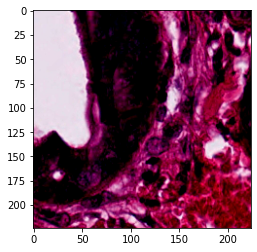

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(val_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def validation(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    y=[]
    y_pred=[]
    prob=[]
    for data, target in test_loader:
        t=target.tolist()
        y.append(t)
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        p=output.tolist()
        prob.append(p)     
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True)
        m=pred.tolist()
        y_pred.append(m) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg, y,y_pred,prob

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

accuracy=[]
for t in range(5):
  print ("Experiment: ", t+1)
  num_epoch = 30

  acc=0
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = densenet121().to(device)
  learning_rate = 0.001
  weight_decay = 0.001
  for param in model.parameters():
      param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)
  for epoch in range(1, num_epoch + 1):
      print(epoch)
      tl=train(model, device, train_loader, optimizer)
      stl,acct=validation(model, device, val_loader)
      if acc<acct:
        if path.exists("DenseNet2categoriesmodel.pth"):
          os.remove("DenseNet2categoriesmodel.pth")

        torch.save(model.state_dict(), 'DenseNet2categoriesmodel.pth')
        acc=acct
   


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = densenet121()
  model.load_state_dict(torch.load('DenseNet2categoriesmodel.pth', map_location=device))
  model=model.to(device)

  stl,acct,y,y_pred,prob=test(model, device, test_loader)
  accuracy.append(acct)


print(accuracy)


Experiment:  1
1


<ipython-input-12-11d4e74c9e3a>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2646

Test: Average loss: 0.4094, Accuracy: 7997/9096 (87.92%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1435

Test: Average loss: 0.1213, Accuracy: 8691/9096 (95.55%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1098

Test: Average loss: 0.1202, Accuracy: 8689/9096 (95.53%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1018

Test: Average loss: 0.1233, Accuracy: 8678/9096 (95.40%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0908

Test: Average loss: 0.0795, Accuracy: 8857/9096 (97.37%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0785

Test: Average loss: 0.1004, Accuracy: 8762/9096 (96.33%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0741

Test: Average loss: 0.0854, Accuracy: 8860/9096 (97.41%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0683

Test: Average loss: 0.1476, Accuracy: 8638/9096 (94.96%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0642

Test: Average loss: 0.1124, Accuracy: 8690/9096 (95.54%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0586

Test: Average loss: 0.1020, Accuracy: 8778/9096 (96.50%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0556

Test: Average loss: 0.1243, Accuracy: 8679/9096 (95.42%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0571

Test: Average loss: 0.0815, Accuracy: 8803/9096 (96.78%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0495

Test: Average loss: 0.1090, Accuracy: 8746/9096 (96.15%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0493

Test: Average loss: 0.0567, Accuracy: 8937/9096 (98.25%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0443

Test: Average loss: 0.2296, Accuracy: 8513/9096 (93.59%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0424

Test: Average loss: 0.0508, Accuracy: 8951/9096 (98.41%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0392

Test: Average loss: 0.1374, Accuracy: 8708/9096 (95.73%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0394

Test: Average loss: 0.0567, Accuracy: 8934/9096 (98.22%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0376

Test: Average loss: 0.0527, Accuracy: 8946/9096 (98.35%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0397

Test: Average loss: 0.0687, Accuracy: 8886/9096 (97.69%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0328

Test: Average loss: 0.0838, Accuracy: 8840/9096 (97.19%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0369

Test: Average loss: 0.0569, Accuracy: 8885/9096 (97.68%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0311

Test: Average loss: 0.0642, Accuracy: 8894/9096 (97.78%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0321

Test: Average loss: 0.0586, Accuracy: 8890/9096 (97.74%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0267

Test: Average loss: 0.0465, Accuracy: 8973/9096 (98.65%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0302

Test: Average loss: 0.0374, Accuracy: 8965/9096 (98.56%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0283

Test: Average loss: 0.0631, Accuracy: 8872/9096 (97.54%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0282

Test: Average loss: 0.1234, Accuracy: 8937/9096 (98.25%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0238

Test: Average loss: 0.0523, Accuracy: 8922/9096 (98.09%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0236

Test: Average loss: 0.0637, Accuracy: 8905/9096 (97.90%)

Test: Average loss: 0.0403, Accuracy: 7108/7200 (98.72%)

Experiment:  2
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2699

Test: Average loss: 0.2173, Accuracy: 8442/9096 (92.81%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1449

Test: Average loss: 0.2441, Accuracy: 8345/9096 (91.74%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1150

Test: Average loss: 0.1298, Accuracy: 8656/9096 (95.16%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0976

Test: Average loss: 0.0970, Accuracy: 8760/9096 (96.31%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0864

Test: Average loss: 0.1691, Accuracy: 8531/9096 (93.79%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0794

Test: Average loss: 0.2032, Accuracy: 8436/9096 (92.74%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0705

Test: Average loss: 0.0613, Accuracy: 8917/9096 (98.03%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0692

Test: Average loss: 1.9498, Accuracy: 8582/9096 (94.35%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0627

Test: Average loss: 0.1012, Accuracy: 8757/9096 (96.27%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0604

Test: Average loss: 0.2649, Accuracy: 8481/9096 (93.24%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0526

Test: Average loss: 0.1801, Accuracy: 8579/9096 (94.32%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0515

Test: Average loss: 0.1313, Accuracy: 8752/9096 (96.22%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0467

Test: Average loss: 0.0991, Accuracy: 8807/9096 (96.82%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0477

Test: Average loss: 0.2005, Accuracy: 8623/9096 (94.80%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0441

Test: Average loss: 0.0842, Accuracy: 8885/9096 (97.68%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0399

Test: Average loss: 0.1116, Accuracy: 8773/9096 (96.45%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0418

Test: Average loss: 0.0817, Accuracy: 8875/9096 (97.57%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0374

Test: Average loss: 0.1247, Accuracy: 8785/9096 (96.58%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0398

Test: Average loss: 0.1528, Accuracy: 8753/9096 (96.23%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0340

Test: Average loss: 0.1349, Accuracy: 8893/9096 (97.77%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0344

Test: Average loss: 0.1690, Accuracy: 8726/9096 (95.93%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0313

Test: Average loss: 0.1305, Accuracy: 8749/9096 (96.19%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0301

Test: Average loss: 0.0811, Accuracy: 8913/9096 (97.99%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0299

Test: Average loss: 0.0580, Accuracy: 8916/9096 (98.02%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0293

Test: Average loss: 0.0555, Accuracy: 8936/9096 (98.24%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0282

Test: Average loss: 0.1007, Accuracy: 8787/9096 (96.60%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0298

Test: Average loss: 0.1234, Accuracy: 8873/9096 (97.55%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0249

Test: Average loss: 0.0641, Accuracy: 8893/9096 (97.77%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0227

Test: Average loss: 0.1829, Accuracy: 8632/9096 (94.90%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0259

Test: Average loss: 0.0873, Accuracy: 8854/9096 (97.34%)

Test: Average loss: 0.0524, Accuracy: 7066/7200 (98.14%)

Experiment:  3
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2824

Test: Average loss: 0.1981, Accuracy: 8431/9096 (92.69%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1421

Test: Average loss: 0.1463, Accuracy: 8637/9096 (94.95%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1113

Test: Average loss: 0.1610, Accuracy: 8627/9096 (94.84%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0978

Test: Average loss: 0.1961, Accuracy: 8379/9096 (92.12%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0861

Test: Average loss: 0.4523, Accuracy: 8181/9096 (89.94%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0788

Test: Average loss: 0.1662, Accuracy: 8526/9096 (93.73%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0723

Test: Average loss: 0.0867, Accuracy: 8799/9096 (96.73%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0678

Test: Average loss: 0.1206, Accuracy: 8678/9096 (95.40%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0601

Test: Average loss: 0.0619, Accuracy: 8913/9096 (97.99%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0580

Test: Average loss: 0.1107, Accuracy: 8720/9096 (95.87%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0540

Test: Average loss: 0.1841, Accuracy: 8551/9096 (94.01%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0540

Test: Average loss: 0.0932, Accuracy: 8730/9096 (95.98%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.1383, Accuracy: 8688/9096 (95.51%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0479

Test: Average loss: 0.2304, Accuracy: 8589/9096 (94.43%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0462

Test: Average loss: 0.1394, Accuracy: 8748/9096 (96.17%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0449

Test: Average loss: 0.1241, Accuracy: 8723/9096 (95.90%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0422

Test: Average loss: 0.0972, Accuracy: 8704/9096 (95.69%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0403

Test: Average loss: 0.1395, Accuracy: 8740/9096 (96.09%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0365

Test: Average loss: 0.1179, Accuracy: 8749/9096 (96.19%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0343

Test: Average loss: 0.2061, Accuracy: 8606/9096 (94.61%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0324

Test: Average loss: 0.1807, Accuracy: 8685/9096 (95.48%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0343

Test: Average loss: 0.2447, Accuracy: 8729/9096 (95.97%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0322

Test: Average loss: 0.1127, Accuracy: 8742/9096 (96.11%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0320

Test: Average loss: 0.1536, Accuracy: 8834/9096 (97.12%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0287

Test: Average loss: 0.0873, Accuracy: 8837/9096 (97.15%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0267

Test: Average loss: 0.1161, Accuracy: 8819/9096 (96.95%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0280

Test: Average loss: 0.1360, Accuracy: 8800/9096 (96.75%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0272

Test: Average loss: 0.0718, Accuracy: 8890/9096 (97.74%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0267

Test: Average loss: 0.2336, Accuracy: 8787/9096 (96.60%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0236

Test: Average loss: 0.1081, Accuracy: 8867/9096 (97.48%)

Test: Average loss: 0.0555, Accuracy: 7069/7200 (98.18%)

Experiment:  4
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2825

Test: Average loss: 0.1760, Accuracy: 8567/9096 (94.18%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1464

Test: Average loss: 0.2133, Accuracy: 8426/9096 (92.63%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1141

Test: Average loss: 0.1178, Accuracy: 8691/9096 (95.55%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0962

Test: Average loss: 0.3159, Accuracy: 8360/9096 (91.91%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0859

Test: Average loss: 0.0936, Accuracy: 8828/9096 (97.05%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0813

Test: Average loss: 0.0983, Accuracy: 8761/9096 (96.32%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0732

Test: Average loss: 0.2714, Accuracy: 8481/9096 (93.24%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0667

Test: Average loss: 0.1626, Accuracy: 8580/9096 (94.33%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0618

Test: Average loss: 0.1115, Accuracy: 8750/9096 (96.20%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0568

Test: Average loss: 0.0672, Accuracy: 8898/9096 (97.82%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0526

Test: Average loss: 0.1472, Accuracy: 8684/9096 (95.47%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0508

Test: Average loss: 0.0705, Accuracy: 8874/9096 (97.56%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0492

Test: Average loss: 0.0690, Accuracy: 8925/9096 (98.12%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0442

Test: Average loss: 0.0698, Accuracy: 8900/9096 (97.85%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0461

Test: Average loss: 0.0849, Accuracy: 8835/9096 (97.13%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0413

Test: Average loss: 0.0602, Accuracy: 8921/9096 (98.08%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0413

Test: Average loss: 0.1116, Accuracy: 8726/9096 (95.93%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0384

Test: Average loss: 0.0956, Accuracy: 8806/9096 (96.81%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0388

Test: Average loss: 0.0756, Accuracy: 8830/9096 (97.08%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0333

Test: Average loss: 0.0567, Accuracy: 8953/9096 (98.43%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0315

Test: Average loss: 0.0538, Accuracy: 8952/9096 (98.42%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0304

Test: Average loss: 0.0795, Accuracy: 8853/9096 (97.33%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0333

Test: Average loss: 0.1023, Accuracy: 8794/9096 (96.68%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0296

Test: Average loss: 0.1208, Accuracy: 8782/9096 (96.55%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0292

Test: Average loss: 0.1108, Accuracy: 8881/9096 (97.64%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0244

Test: Average loss: 0.0970, Accuracy: 8828/9096 (97.05%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0257

Test: Average loss: 0.0562, Accuracy: 8931/9096 (98.19%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0259

Test: Average loss: 0.0793, Accuracy: 8818/9096 (96.94%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0234

Test: Average loss: 0.0739, Accuracy: 8854/9096 (97.34%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0233

Test: Average loss: 0.1035, Accuracy: 8861/9096 (97.42%)

Test: Average loss: 0.0420, Accuracy: 7095/7200 (98.54%)

Experiment:  5
1


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2725

Test: Average loss: 0.3319, Accuracy: 8379/9096 (92.12%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1463

Test: Average loss: 0.1783, Accuracy: 8514/9096 (93.60%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1115

Test: Average loss: 0.2945, Accuracy: 8435/9096 (92.73%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0985

Test: Average loss: 0.3681, Accuracy: 8218/9096 (90.35%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0845

Test: Average loss: 0.0586, Accuracy: 8926/9096 (98.13%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0765

Test: Average loss: 0.0841, Accuracy: 8840/9096 (97.19%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0724

Test: Average loss: 0.0897, Accuracy: 8870/9096 (97.52%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0656

Test: Average loss: 0.0805, Accuracy: 8875/9096 (97.57%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0665

Test: Average loss: 0.1093, Accuracy: 8781/9096 (96.54%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0575

Test: Average loss: 0.1554, Accuracy: 8563/9096 (94.14%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0565

Test: Average loss: 0.0938, Accuracy: 8786/9096 (96.59%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.1693, Accuracy: 8679/9096 (95.42%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0478

Test: Average loss: 0.0878, Accuracy: 8782/9096 (96.55%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0494

Test: Average loss: 0.1185, Accuracy: 8732/9096 (96.00%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0421

Test: Average loss: 0.0641, Accuracy: 8931/9096 (98.19%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0392

Test: Average loss: 0.1234, Accuracy: 8733/9096 (96.01%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0400

Test: Average loss: 0.0741, Accuracy: 8874/9096 (97.56%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0408

Test: Average loss: 0.0590, Accuracy: 8897/9096 (97.81%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0381

Test: Average loss: 0.0497, Accuracy: 8956/9096 (98.46%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

accuracy=[]
for t in range(1):
  print ("Experiment: ", t+1)
  num_epoch = 30

  acc=0
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = densenet121().to(device)
  learning_rate = 0.001
  weight_decay = 0.001
  for param in model.parameters():
      param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)
  for epoch in range(1, num_epoch + 1):
      print(epoch)
      tl=train(model, device, train_loader, optimizer)
      stl,acct=validation(model, device, val_loader)
      if acc<acct:
        if path.exists("DenseNet2categoriesmodel.pth"):
          os.remove("DenseNet2categoriesmodel.pth")

        torch.save(model.state_dict(), 'DenseNet2categoriesmodel.pth')
        acc=acct
   


  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = densenet121()
  model.load_state_dict(torch.load('DenseNet2categoriesmodel.pth', map_location=device))
  model=model.to(device)

  stl,acct,y,y_pred,prob=test(model, device, test_loader)
  accuracy.append(acct)


print(accuracy)


Experiment:  1
1


<ipython-input-11-11d4e74c9e3a>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.2767

Test: Average loss: 0.3538, Accuracy: 8026/9096 (88.24%)

2


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1482

Test: Average loss: 0.2322, Accuracy: 8715/9096 (95.81%)

3


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.1126

Test: Average loss: 0.1309, Accuracy: 8679/9096 (95.42%)

4


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0958

Test: Average loss: 0.1184, Accuracy: 8800/9096 (96.75%)

5


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0901

Test: Average loss: 0.1877, Accuracy: 8479/9096 (93.22%)

6


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0786

Test: Average loss: 0.1818, Accuracy: 8467/9096 (93.08%)

7


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0698

Test: Average loss: 0.1787, Accuracy: 8630/9096 (94.88%)

8


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0636

Test: Average loss: 0.0716, Accuracy: 8885/9096 (97.68%)

9


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0611

Test: Average loss: 0.1413, Accuracy: 8694/9096 (95.58%)

10


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0565

Test: Average loss: 0.1010, Accuracy: 8848/9096 (97.27%)

11


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0524

Test: Average loss: 0.1903, Accuracy: 8828/9096 (97.05%)

12


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0529

Test: Average loss: 0.0815, Accuracy: 8835/9096 (97.13%)

13


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0473

Test: Average loss: 0.0768, Accuracy: 8854/9096 (97.34%)

14


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0456

Test: Average loss: 0.4280, Accuracy: 8129/9096 (89.37%)

15


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0428

Test: Average loss: 0.1267, Accuracy: 8783/9096 (96.56%)

16


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0451

Test: Average loss: 0.1854, Accuracy: 8654/9096 (95.14%)

17


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0388

Test: Average loss: 0.0911, Accuracy: 8774/9096 (96.46%)

18


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0378

Test: Average loss: 0.0632, Accuracy: 8911/9096 (97.97%)

19


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0379

Test: Average loss: 0.0665, Accuracy: 8892/9096 (97.76%)

20


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0346

Test: Average loss: 0.0951, Accuracy: 8796/9096 (96.70%)

21


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0321

Test: Average loss: 0.0641, Accuracy: 8920/9096 (98.07%)

22


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0305

Test: Average loss: 0.0799, Accuracy: 8859/9096 (97.39%)

23


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0371

Test: Average loss: 0.0553, Accuracy: 8935/9096 (98.23%)

24


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0316

Test: Average loss: 0.0794, Accuracy: 8917/9096 (98.03%)

25


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0312

Test: Average loss: 0.0487, Accuracy: 8970/9096 (98.61%)

26


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0296

Test: Average loss: 0.0882, Accuracy: 8790/9096 (96.64%)

27


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0258

Test: Average loss: 0.0754, Accuracy: 8854/9096 (97.34%)

28


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0273

Test: Average loss: 0.0601, Accuracy: 8942/9096 (98.31%)

29


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0225

Test: Average loss: 0.0552, Accuracy: 8939/9096 (98.27%)

30


  0%|          | 0/4245 [00:00<?, ?it/s]

Train: Average loss: 0.0228

Test: Average loss: 0.0900, Accuracy: 8829/9096 (97.06%)

Test: Average loss: 0.0408, Accuracy: 7113/7200 (98.79%)

[98.79166666666667]
